# 対数を取るか否か
**変数**変換は安易に行うことは注意したい。しかし対数変換は解釈がしやすく、時に有用。

## 対象データ
- 関東近郊の架空の賃貸物件のデータ（`data-rental.txt`）
- 応答変数$`Y`$: ２年間のトータル費用
- 説明変数$`Area`$：物件の広さ

散布図を見て、対数変換バージョンも用意。単回帰を二通りで試してみる。  
つまり  
 $Area$ → $\mu$ → +noise → $Y$

In [11]:
### インポート

# 数値・確率計算
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyMC
import pymc as pm
import arviz as az

# 描画
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
import seaborn as sns
# plt.rcParams['font.family'] = 'Meiryo'

# ワーニング表示の抑制
import warnings
warnings.simplefilter('ignore')

In [3]:
### データの読み込み ◆data-rental.txt
# Y:2年間のトータル費用(万円), Area:物件の広さ(m²)

data = pd.read_csv('./input/data-rental.txt')
print('data.shape: ', data.shape)
display(data.head())

data.shape:  (100, 2)


,Y,Area
0,263.062,40.66
1,519.000,61.94
2,671.400,55.13
3,473.030,56.82
4,455.600,56.82


In [4]:
data.describe()

,Y,Area
count,100.000000,100.000000
mean,365.532010,36.700500
std,292.191219,18.752761
min,124.600000,11.640000
25%,195.850000,23.062500
50%,261.531000,31.780000
75%,432.550000,45.247500
max,1870.500000,112.820000


In [5]:
data.corr()

,Y,Area
Y,1.00000,0.89784
Area,0.89784,1.00000


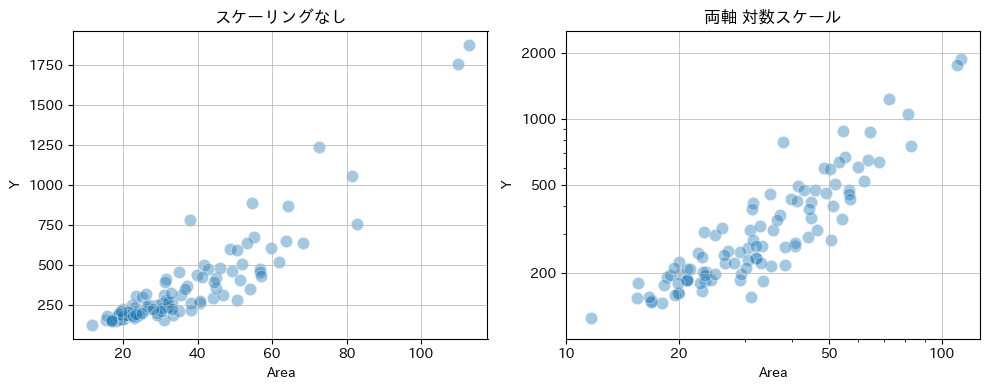

In [12]:
# 散布図

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(ax=ax1, x="Area", y="Y", data=data, s=80, alpha=0.4)
ax1.set(title="スケーリングなし")
ax1.grid(lw=0.5)

sns.scatterplot(ax=ax2, x="Area", y="Y", data=data, s=80, alpha=0.4)
ax2.set(xscale="log", 
        xticks=(10, 20, 50, 100), xticklabels=(10, 20, 50, 100),
        yscale="log", ylim=(100, 2500),
        yticks=(200, 500, 1000, 2000), yticklabels=(200, 500, 1000, 2000),
        title="両軸 対数スケール")
ax2.grid(lw=0.5)
plt.tight_layout()


## モデル式

$$ \mu[n] = b_1 + b_2 Area[n] $$
$$ Y[n] \sim Normal(\mu[n], \sigma_Y) $$

$n$は物件のインデックスであることに注意  
目的は$b_1, b_2, \sigma_Y$の分布推定ということになる。

２つ目のモデルは  
 $\log_{10}(Area)$ → $\mu$ → +noise → $\log_{10}(Y)$

$$ \mu[n] = b_1 + b_2 \log_{10}(Area[n]) $$
$$ \log_{10}(Y[n]) \sim Normal(\mu[n], \sigma_Y) $$



In [20]:
# Areaの値の設定
Area_new = np.linspace(10, 120, 50)

with pm.Model() as model1:
    ## coordの定義
    model1.add_coord("data", values=data.index, mutable=True)
    model1.add_coord("dataNew", values=range(len(Area_new)), mutable=True)

    ## dataの定義
    Y = pm.ConstantData("Y", value=data["Y"].values, dims="data")
    Area = pm.ConstantData("Area", value=data["Area"].values, dims="data")
    ## ↓予測用説明変数
    AreaNew = pm.ConstantData("AreaNew", value=Area_new, dims="dataNew")

    ### 事前分布
    b1 = pm.Uniform("b1", lower=-1000, upper=1000)
    b2 = pm.Uniform("b2", lower=-1000, upper=1000)
    sigma = pm.Uniform("sigma", lower=0, upper=1000)

    ### 線形予測
    mu = pm.Deterministic("mu", b1 + b2*Area, dims="data")
    
    ### 尤度関数
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=Y, dims="data")

    ### 計算値
    yPred = pm.Normal("yPred", mu=mu, sigma=sigma, dims="data")
    yNew = pm.Normal("yNew", mu=b1+b2*AreaNew, sigma=sigma, dims="dataNew")

model1

   b1 ~ Uniform(-1e+03, 1e+03)
   b2 ~ Uniform(-1e+03, 1e+03)
sigma ~ Uniform(0, 1e+03)
yPred ~ Normal(mu, sigma)
 yNew ~ Normal(f(b1, b2), sigma)
   mu ~ Deterministic(f(b1, b2))
  obs ~ Normal(mu, sigma)

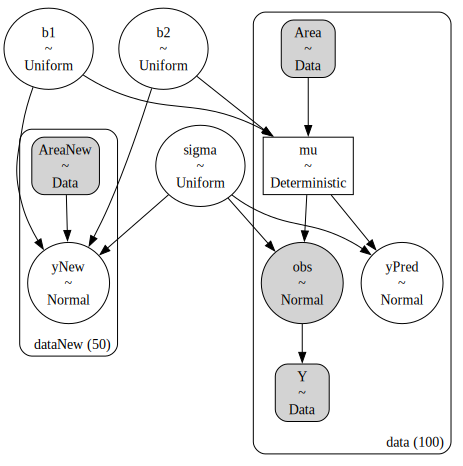

In [21]:
### モデルの可視化
pm.model_to_graphviz(model1)

In [22]:
with model1:
    idata1 = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8, 
                       nuts_sampler="numpyro", random_seed=12)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]





Running chain 0:   5%|▌         | 100/2000 [00:02<00:03, 475.47it/s]


Running chain 0:  10%|█         | 200/2000 [00:02<00:02, 612.42it/s]


Running chain 0:  75%|███████▌  | 1500/2000 [00:02<00:00, 3780.43it/s]




Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 758.49it/s] 


In [24]:
## rhat > 1.1の確認
# 設定
idata_in = idata1 
threshold = 1.01

# 閾値を超えるR_hat個数を表示
print((az.rhat(idata_in) > threshold).sum())

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    b1       int64 8B 0
    b2       int64 8B 0
    mu       int64 8B 0
    sigma    int64 8B 0
    yNew     int64 8B 0
    yPred    int64 8B 0


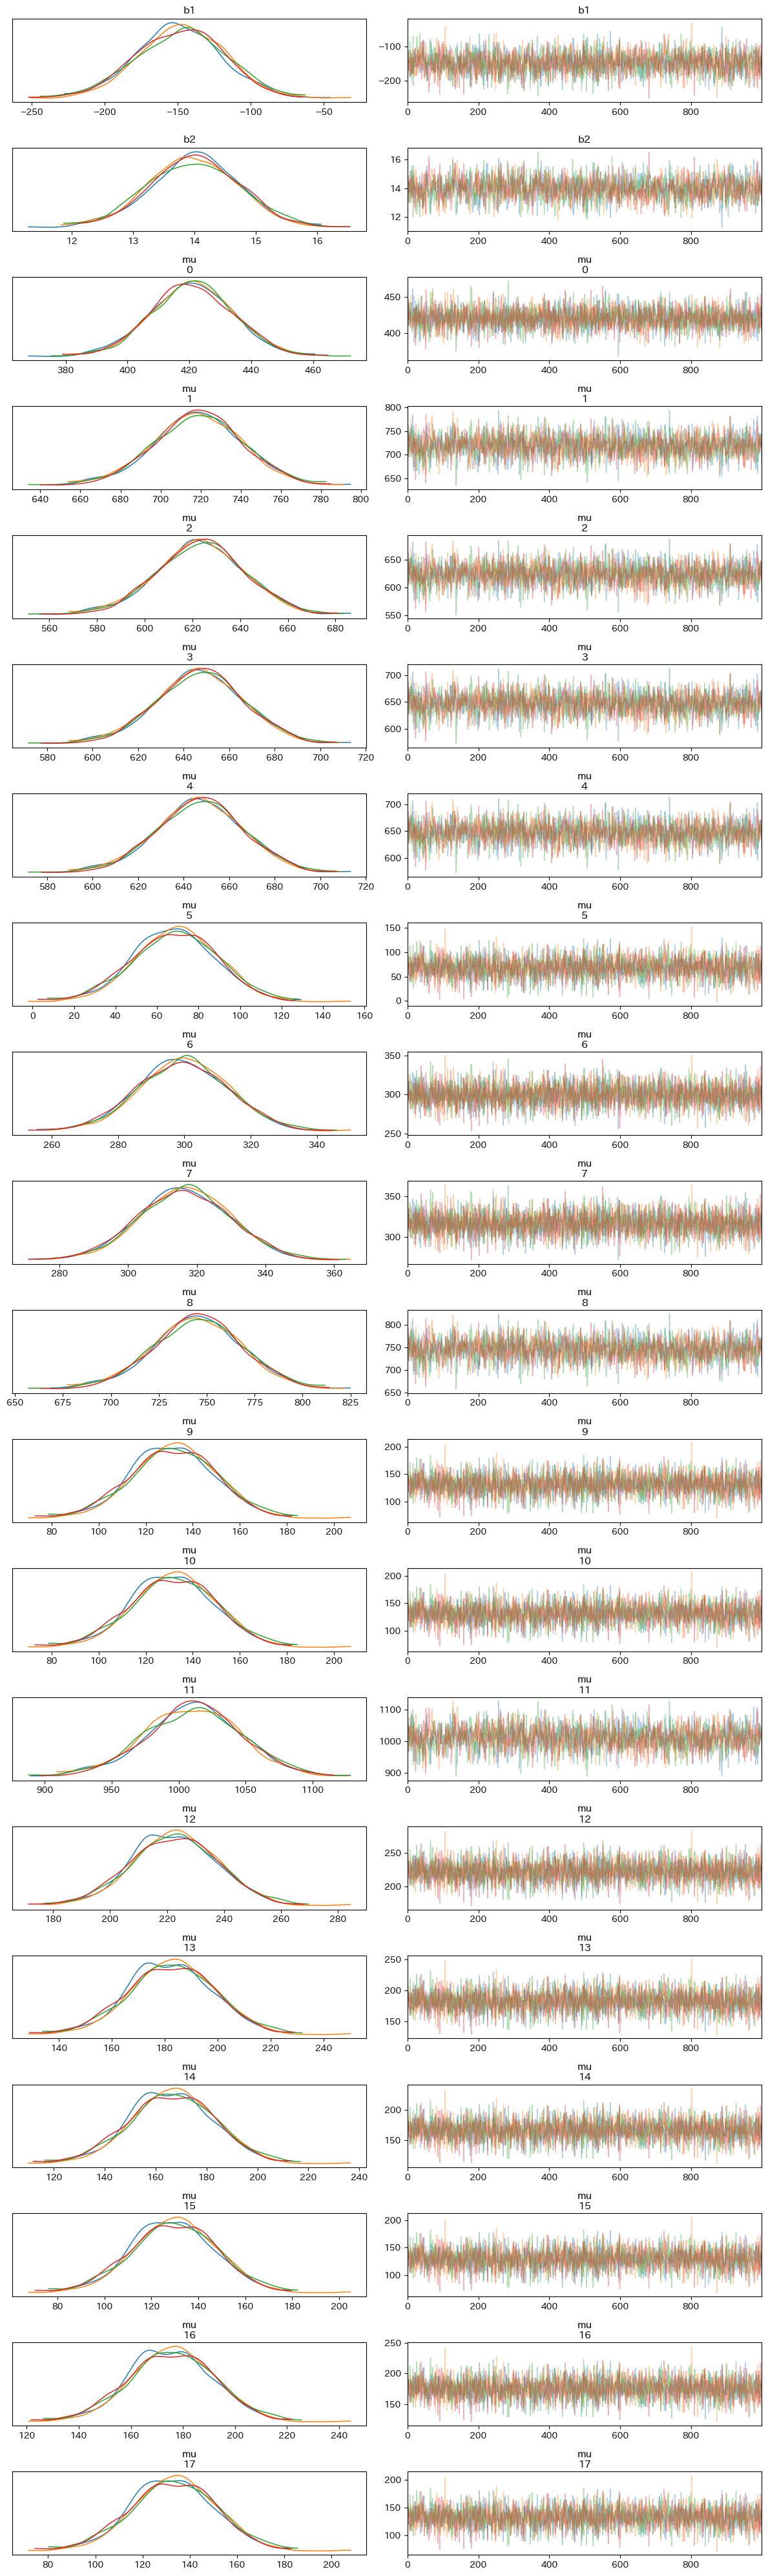

In [26]:
### トレースプロットの表示
var_names = ["b1", "b2", "mu", "sigma"]
pm.plot_trace(idata1, compact=False, var_names=var_names)
plt.tight_layout();

In [27]:
### 推論データの要約統計情報の表示
pm.summary(idata1, hdi_prob=0.95, var_names=var_names, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,-148.016,29.836,-203.842,-87.673,0.691,0.489,1871.464,2689.180,1.000
b2,13.992,0.727,12.439,15.321,0.019,0.014,1396.187,2339.479,1.001
mu[0],420.889,13.305,395.350,447.721,0.235,0.166,3206.271,3185.262,1.000
mu[1],718.634,22.376,676.224,764.380,0.564,0.399,1572.712,2564.171,1.001
mu[2],623.350,18.574,586.787,659.923,0.445,0.314,1743.998,2687.758,1.000
...,...,...,...,...,...,...,...,...,...
mu[96],244.733,14.525,217.643,274.408,0.248,0.176,3422.805,3605.479,1.000
mu[97],687.432,21.079,647.166,730.236,0.524,0.371,1614.815,2635.529,1.001
mu[98],312.033,13.350,285.284,337.115,0.218,0.155,3753.531,3543.080,1.000
mu[99],428.445,13.390,401.964,454.622,0.239,0.169,3131.316,3212.445,1.000


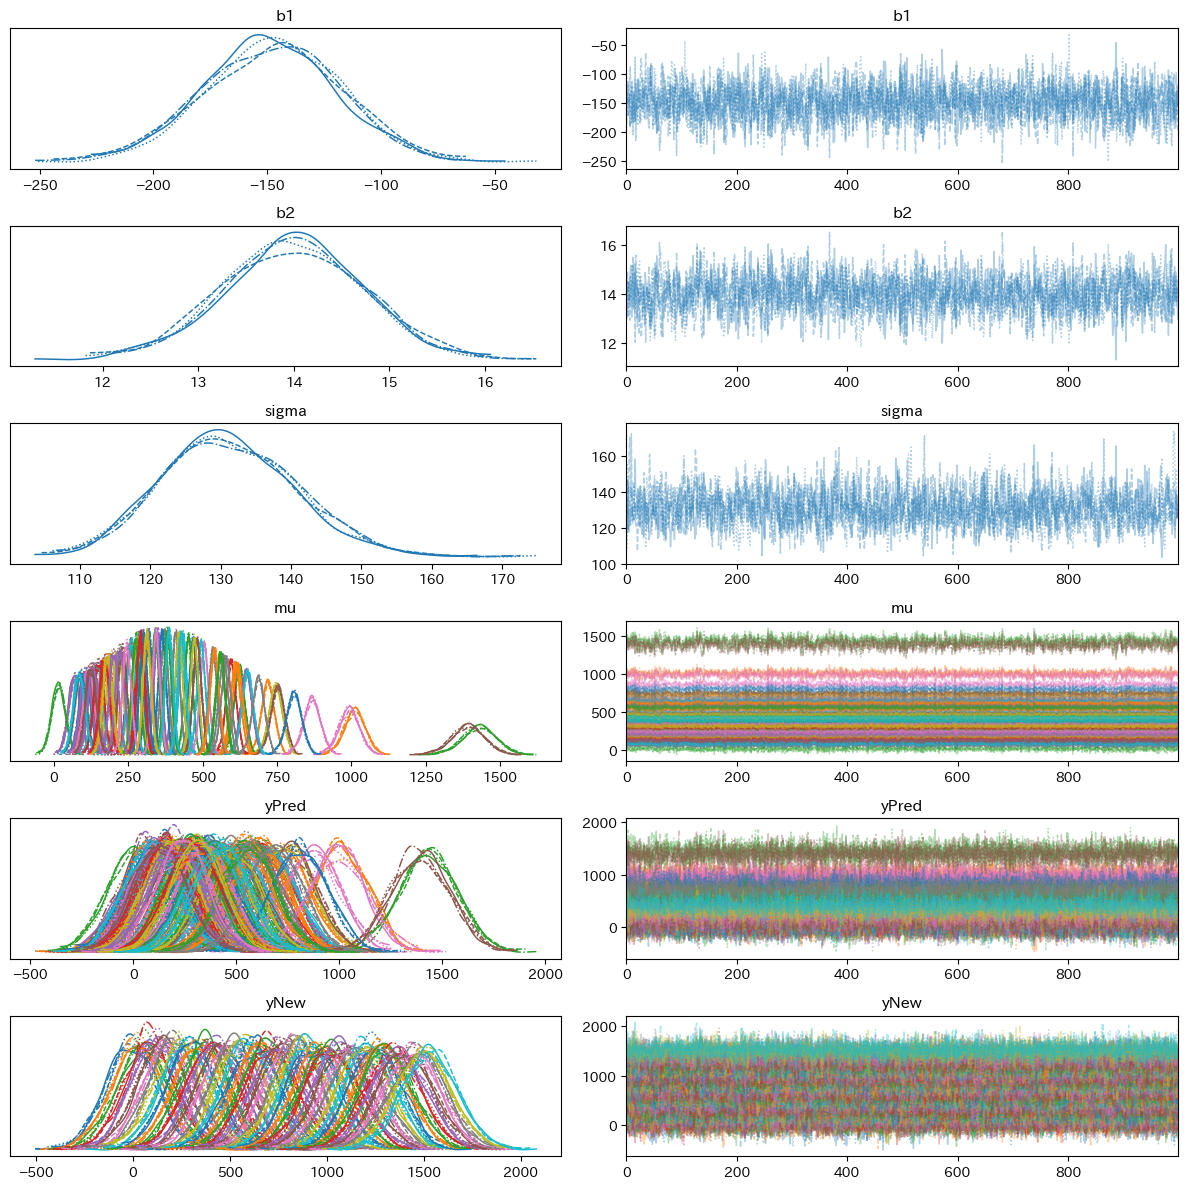

In [28]:
### トレースプロットの表示
var_names = ['b1', 'b2', 'sigma', 'mu', 'yPred', 'yNew']
pm.plot_trace(idata1, compact=True, var_names=var_names)
plt.tight_layout();

In [29]:
### パラメータの要約を確認

# mean,sd,2.5%,25%,50%,75%,97.5%パーセンタイル点をデータフレーム化する関数の定義
def make_stats_df(y):
    probs = [2.5, 25, 50, 75, 97.5]
    columns = ['mean', 'sd'] + [str(s) + '%' for s in probs]
    quantiles = pd.DataFrame(np.percentile(y, probs, axis=0).T, index=y.columns)
    tmp_df = pd.concat([y.mean(axis=0), y.std(axis=0), quantiles], axis=1)
    tmp_df.columns=columns
    return tmp_df

# 要約統計量の算出・表示
vars = ['b1', 'b2', 'sigma']
param_samples = idata1.posterior[vars].to_dataframe().reset_index(drop=True)
display(make_stats_df(param_samples).round(2))

,mean,sd,2.5%,25%,50%,75%,97.5%
b1,-148.02,29.84,-206.88,-168.02,-147.48,-127.89,-90.35
b2,13.99,0.73,12.53,13.50,13.99,14.48,15.43
sigma,131.18,9.74,113.51,124.47,130.64,137.62,151.37
